# Precipitation Time Series During Pluvials

### Start Clean

In [15]:
# Reset the environment (start clean)
%reset -f

# Import Modules and define functions
import calendar
import datetime
import os
import numpy as np
import numpy.ma as ma
import netCDF4
import matplotlib
import copy
from matplotlib import pyplot as plt
import scipy
import scipy.signal
import scipy.io as sio
import seaborn as sns
import pandas as pd
import scipy.stats as stats
#import statsmodels.api as sm
from IPython.display import display
import IPython
import requests
import pandas as pd
import os
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf 
import matplotlib.colors as colors

# cartopy stuff
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry.polygon import LinearRing
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# Borders for mapping: Cultural borders
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
# Coastline
newcoast = cfeature.NaturalEarthFeature('physical', 'coastline', '10m',
                                        edgecolor='k',
                                        facecolor='none')
#Lakes
newlake = cfeature.NaturalEarthFeature('physical', 'lakes', '10m',
                                        edgecolor='k',
                                        facecolor='none')

# Embeds plots inside the notebook (use in iPython Notebook)
%matplotlib inline

# For asymetric colorbars
# https://matplotlib.org/stable/tutorials/colors/colormapnorms.html?highlight=twoslopenorm#twoslopenorm-different-mapping-on-either-side-of-a-center
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, vcenter=None, clip=False):
        self.vcenter = vcenter
        super().__init__(vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.vcenter, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

# For plotting a rectangle on the maps
def plot_rectangle(ax, lonmin,lonmax,latmin,latmax):
    xs = [lonmin,lonmax,lonmax,lonmin,lonmin]
    ys = [latmin,latmin,latmax,latmax,latmin]
    #ax.plot(xs, ys,latlon = True, color='k', linestyle='--', linewidth=3)
    ax.plot(xs,ys,color='k',linestyle='--',linewidth=3,transform=ccrs.PlateCarree())

# For plotting a point on a map
def plot_point(ax,lon,lat):
    xs = [lon]
    ys = [lat]
    #ax.plot(xs, ys,latlon = True, color='k', linestyle='--', linewidth=3)
    #ax.scatter(xs,ys,color=np.array([0.5,0.5,0.5]),marker='*',linewidth=3,transform=ccrs.PlateCarree())
    ax.scatter(xs,ys,color='k',edgecolors='k',marker='+',linewidth=0.5,s=5,transform=ccrs.PlateCarree(),zorder=2,alpha=0.5)

ocean_color = np.float64([209,230,241])/255
nmap=plt.get_cmap(name=plt.cm.BrBG,lut=12) # only needed to set bins for pcolor/pcolormesh
      
# Month Vector
mons     = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

# Set plot styles
# Formatting for titles
fontdict_title = {'fontsize': 36}
fig_size = np.array([10,10])

# Formatting for figures
style_new = {'xtick.direction': 'in', \
             'ytick.direction': 'in', \
             'font.sans-serif': 'Arial'}


## Load and Plot SM-REC for 20th Century

(-3.0, 3.3)

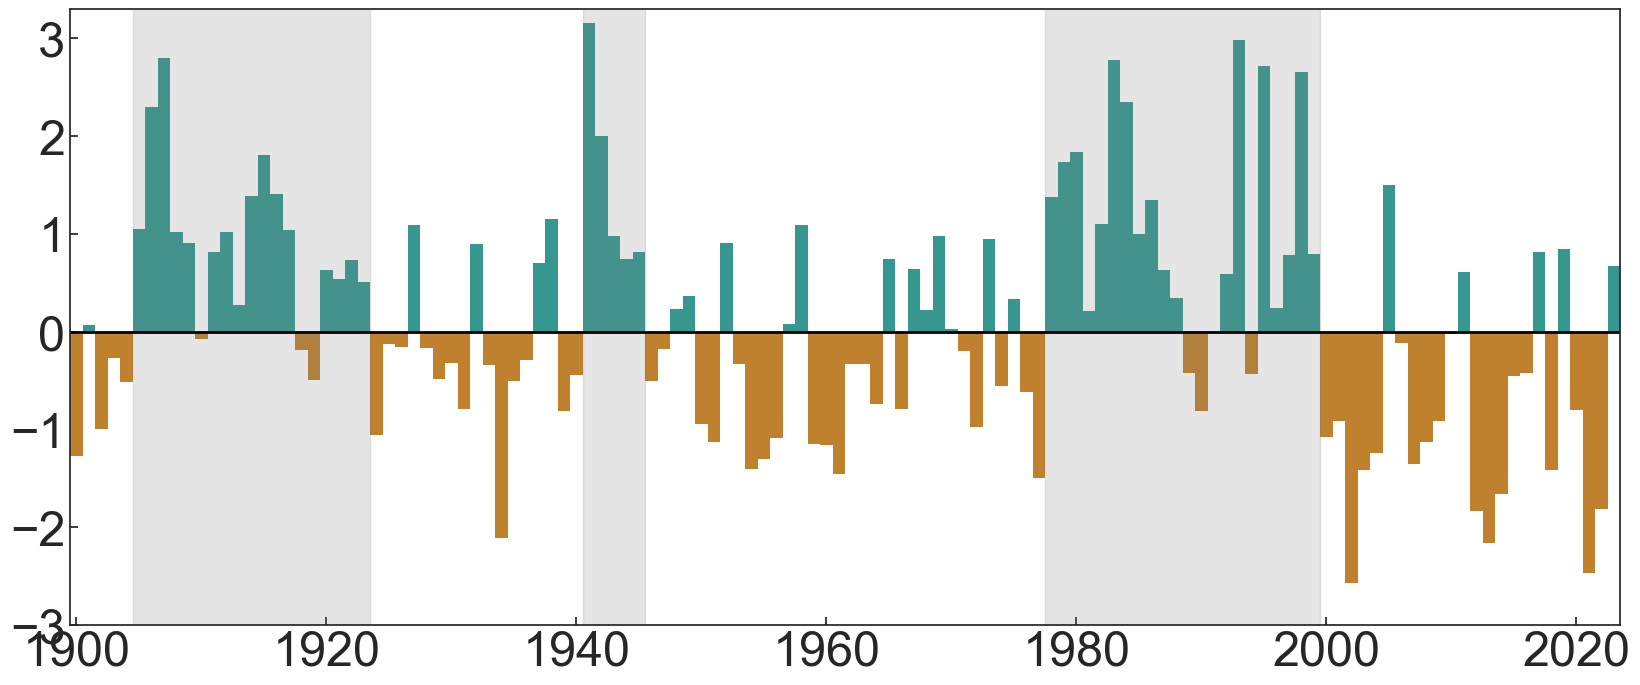

In [16]:
# Load into dataframe
pd_SMseries = pd.read_csv('../data/smrec/recon_2023.txt',delimiter=',')

# Pull out bias-corrected reconustruction and observational time series
sm_obs_yr = np.array(pd_SMseries['year'][:])
sm_obs_all = np.array(pd_SMseries['recon'][:])

# For zero line
y_zeros = np.zeros(sm_obs_yr.shape)

# Separate out positive and negative time series
sm_reg_neg = sm_obs_all.copy(); sm_reg_neg[np.where(sm_obs_all>=0)]=0
sm_reg_pos = sm_obs_all.copy(); sm_reg_pos[np.where(sm_obs_all<0)]=0

ymin=-4
ymax=4

# Figure: unsmoothed
plt.figure(figsize=(20,8),facecolor="white")
sns.set_style("ticks",style_new)
sns.set_context("notebook", font_scale=2.5, rc={"lines.linewidth": 1.5})
#plt.fill_between(np.arange(2000,2020+1), -5, 4,color=[0.8,0.8,0.8], alpha=0.5,zorder=0)
#plt.plot(sm_obs_yr,sm_obs_yr*0,'-', color='k', linewidth=2)
plt.plot(np.arange(1800,2025),np.arange(1800,2025)*0,'-', color='k', linewidth=2)
#plt.plot(sm_obs_yr,sm_obs_all,color='k',linewidth=1)
# Shading
#i_neg=prec_region.copy(); i_neg[np.where(i_neg>=0)]=0; i_neg[np.where(i_neg<0)]=1
#i_pos=prec_region.copy(); i_pos[np.where(i_neg==0)]=1; i_pos[np.where(i_neg==1)]=0
#plt.fill_between(yrs_seas, yrs_seas*0, prec_region, where=i_neg, color='#bf812d', alpha=1)
#plt.fill_between(yrs_seas, yrs_seas*0, prec_region, where=i_pos, color='#35978f', alpha=1)
plt.bar(sm_obs_yr, sm_reg_neg, width=1, linewidth=0, color='#bf812d')
plt.bar(sm_obs_yr, sm_reg_pos, width=1, linewidth=0, color='#35978f')
plt.fill_between(np.arange(1904.5,1924.5), ymin, ymax,color='grey',alpha=0.2)
plt.fill_between(np.arange(1940.5,1946.5), ymin, ymax,color='grey',alpha=0.2)
plt.fill_between(np.arange(1977.5,2000.5), ymin, ymax,color='grey',alpha=0.2)
plt.yticks([-3,-2,-1,0,1,2,3],fontsize=35)
plt.xticks([1900,1920,1940,1960,1980,2000,2020],fontsize=35)
#plt.xlim(1891.5,2023.5)
plt.xlim(1899.5,2023.5)
plt.ylim(-3,3.3)
#plt.savefig('../figures/sm200_20thcent_recon_1yr_update.pdf',format='pdf')


## Load Precipitation Data

In [17]:
# Year Vector for Precipitation
yrs = np.arange(1901,2023+1)

# File Name
fname_in   = '../data/prec.nc'
prec_nc    = netCDF4.Dataset(fname_in,"r",format="NETCDF4")
prec       = prec_nc.variables['prec'][:] # get values
lat        = prec_nc.variables['lat'][:] # get values
lon        = prec_nc.variables['lon'][:] # get values
prec_nc.close()

# Reshape
prec_all = np.reshape(prec,(yrs.size,mons.size,lat.size,lon.size))


## Create Seasonal Averages

mon= 9  ind= -1   1901 - 2022
mon= 10  ind= -1   1901 - 2022
mon= 11  ind= -1   1901 - 2022
mon= 12  ind= -1   1901 - 2022
mon= 1  ind= 1   1902 - 2023
mon= 2  ind= 1   1902 - 2023
mon= 3  ind= 1   1902 - 2023
mon= 4  ind= 1   1902 - 2023
mon= 5  ind= 1   1902 - 2023
mon= 6  ind= 1   1902 - 2023
mon= 7  ind= 1   1902 - 2023
mon= 8  ind= 1   1902 - 2023


(<matplotlib.collections.QuadMesh at 0x179e81fa0>,
 <matplotlib.colorbar.Colorbar at 0x178bb5cd0>)

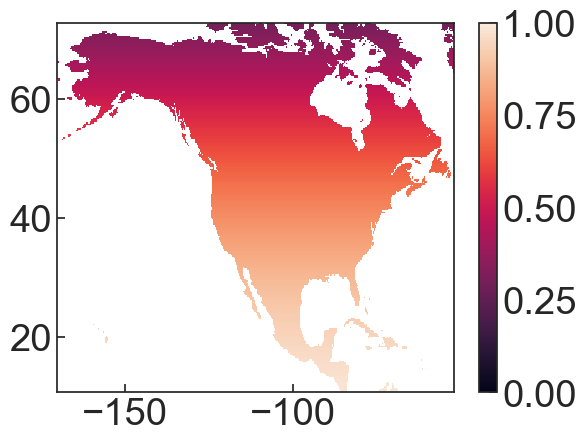

In [18]:
# Seasonal year vector
yrs_seas = np.arange(1902,2023+1)
yr_min   = np.min(yrs_seas)
yr_max   = np.max(yrs_seas)

# Choose Season (name, months, and whether from current or previous year)
#seas_txt = 'ONDJFM'; seas_mons = np.array([10,11,12,1,2,3]); ind_yr = np.array([-1,-1,-1,1,1,1]); ymax=150; ymin=-150; cum_min=-20; cum_max=600
#seas_txt = 'AMJJAS'; seas_mons = np.array([4,5,6,7,8,9]); ind_yr = np.array([1,1,1,1,1,1]); ymax=90; ymin=-77; cum_min=-20; cum_max=310
#seas_txt = 'WYR'; seas_mons = np.array([10,11,12,1,2,3,4,5,6,7,8,9]); ind_yr = np.array([-1,-1,-1,1,1,1,1,1,1,1,1,1]); ymax=200; ymin=-150; cum_min=-20; cum_max=850
seas_txt = 'ADWYR'; seas_mons = np.array([9,10,11,12,1,2,3,4,5,6,7,8]); ind_yr = np.array([-1,-1,-1,-1,1,1,1,1,1,1,1,1]); ymax=200; ymin=-150; cum_min=-20; cum_max=850

# Storage array
seas_prec_mons = np.zeros((seas_mons.size,yrs_seas.size,lat.size,lon.size))*np.nan

# Month Loop
for n_mon in enumerate(seas_mons):
    
    # Pull out month and year lapse info (precipitation data)
    curr_mon = seas_mons[n_mon[0]].copy()
    curr_ind = ind_yr[n_mon[0]].copy()
    
    # Create Year and Month Indices
    i_mon = np.where(mons==curr_mon)[0]
    i_yrs = np.nonzero(np.in1d(yrs,yrs+curr_ind))[0]
   
    # Check
    print('mon=',curr_mon,' ind=',curr_ind,' ',np.min(yrs[i_yrs]),'-',np.max(yrs[i_yrs]))
    
    # Pull out current month of information
    seas_prec_mons[n_mon[0],:,:,:] = np.squeeze(prec_all[:,i_mon,:,:][i_yrs,:,:,:]).copy()
    
# Seasonal average; mask out ocean cells
seas_prec_sum = np.sum(seas_prec_mons,axis=0)
seas_prec_sum[np.where(seas_prec_sum<0)]=np.nan

# Global land/sea mask
mask_global = (seas_prec_sum[10,:,:]*0)+1

# Calculate Climatology
#yrs_clim       = np.arange(1901,2000+1)
yrs_clim       = np.arange(1901,2022+1)
i_yrs_clim     = np.nonzero(np.in1d(yrs_seas,yrs_clim))[0]
seas_prec_clim = np.mean(seas_prec_sum[i_yrs_clim,:,:],axis=0)

# Global Weights
# Create Latitude Weights
lat_wts_glob = np.cos(np.deg2rad(lat));
lat_wts_grid_glob,lon_junk = np.meshgrid(lat_wts_glob,lon)
lat_wts_grid_glob=(np.swapaxes(lat_wts_grid_glob,1,0))*mask_global

plt.figure()
plt.pcolormesh(lon,lat,lat_wts_grid_glob,vmin=0,vmax=1),plt.colorbar()
#plt.pcolor(lon,lat,seas_prec_sum[100,:,:],vmin=0,vmax=1500),plt.colorbar()

## Calculate Regional Average Anomalies

(-150.0, 200.0)

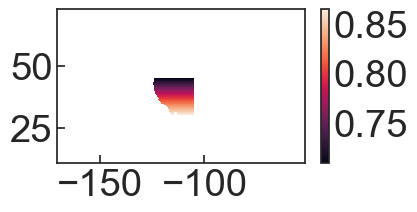

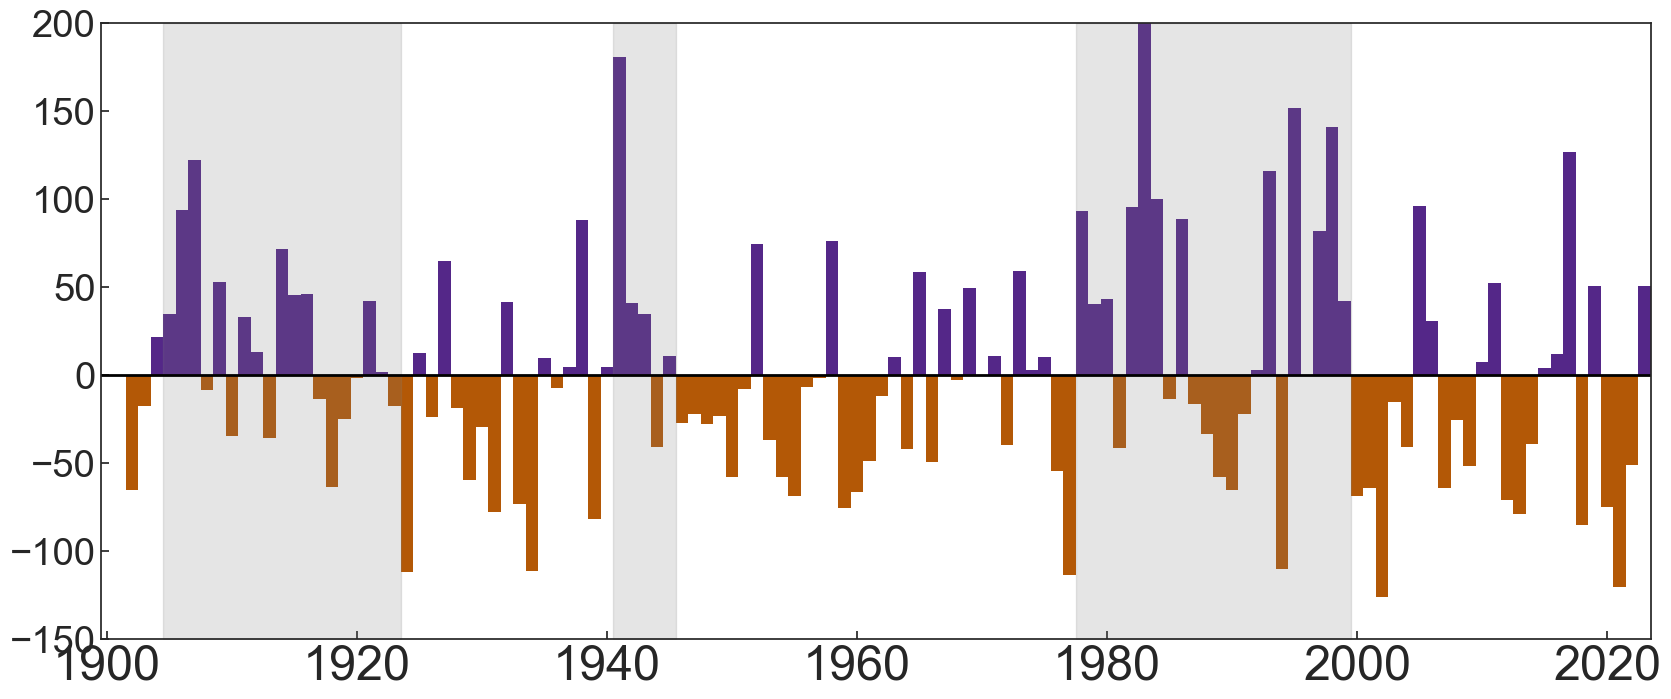

In [19]:
# Anomaly grid, all years
#seas_prec_anom = seas_prec_sum-seas_prec_clim
seas_prec_anom = seas_prec_sum.copy()

# Set up Mask for SWNA-------------------------------------------------------------------------------------
curr_latlon = np.array([-125,-105,30,45])
#curr_latlon = np.array([-125,125,30,45])

# Lat/lon indices for region
i_lon = np.where( (lon>=curr_latlon[0]) & (lon<=curr_latlon[1]) )[0]
i_lat = np.where( (lat>=curr_latlon[2]) & (lat<=curr_latlon[3]) )[0]

# Create mask
mask_region = np.zeros((lat.size,lon.size))*np.nan
mask_region[np.ix_(i_lat,i_lon)] = 0 
mask_region = mask_region+lat_wts_grid_glob

plt.figure(figsize=(4,2))
plt.pcolormesh(lon,lat,mask_region),plt.colorbar()

# Calculate Average---------------------------------------------------------------------------------------
#prec_region = np.nansum(seas_prec_anom*mask_region,axis=(1,2))/np.nansum(mask_region)
prec_region = np.zeros(yrs_seas.size)

for n_yr in enumerate(yrs_seas):
    prec_region[n_yr[0]] = np.nansum(seas_prec_anom[n_yr[0],:,:]*mask_region)/np.nansum(mask_region)

# Mean and anomalize
prec_region_anom = prec_region-np.mean(prec_region)
    
# Separate out positive and negative time series
prec_reg_neg = prec_region_anom.copy(); prec_reg_neg[np.where(prec_region_anom>=0)]=0
prec_reg_pos = prec_region_anom.copy(); prec_reg_pos[np.where(prec_region_anom<0)]=0

# Figure: unsmoothed
plt.figure(figsize=(20,8),facecolor="white")
sns.set_style("ticks",style_new)
sns.set_context("notebook", font_scale=2.5, rc={"lines.linewidth": 1.5})
#plt.fill_between(np.arange(2000,2020+1), -5, 4,color=[0.8,0.8,0.8], alpha=0.5,zorder=0)
plt.plot(np.arange(1800,2025),np.arange(1800,2025)*0,'-', color='k', linewidth=2)
plt.bar(yrs_seas, prec_reg_neg, width=1, linewidth=0, color='#b35806')
plt.bar(yrs_seas, prec_reg_pos, width=1, linewidth=0, color='#542788')
plt.fill_between(np.arange(1904.5,1924.5), ymin, ymax,color='grey',alpha=0.2)
plt.fill_between(np.arange(1940.5,1946.5), ymin, ymax,color='grey',alpha=0.2)
plt.fill_between(np.arange(1977.5,2000.5), ymin, ymax,color='grey',alpha=0.2)
#plt.yticks([-4,-3,-2,-1,0,1,2,3,4],fontsize=35)
plt.xticks([1900,1920,1940,1960,1980,2000,2020],fontsize=35)
plt.xlim(1899.5,2023.5)
plt.ylim(ymin,ymax)
#plt.savefig('../figures/prec_20thcent_'+seas_txt+'_mm.pdf',format='pdf')

## Calculate Cumulative anomalies for Pluvial and 21st Century Megadroughts Periods

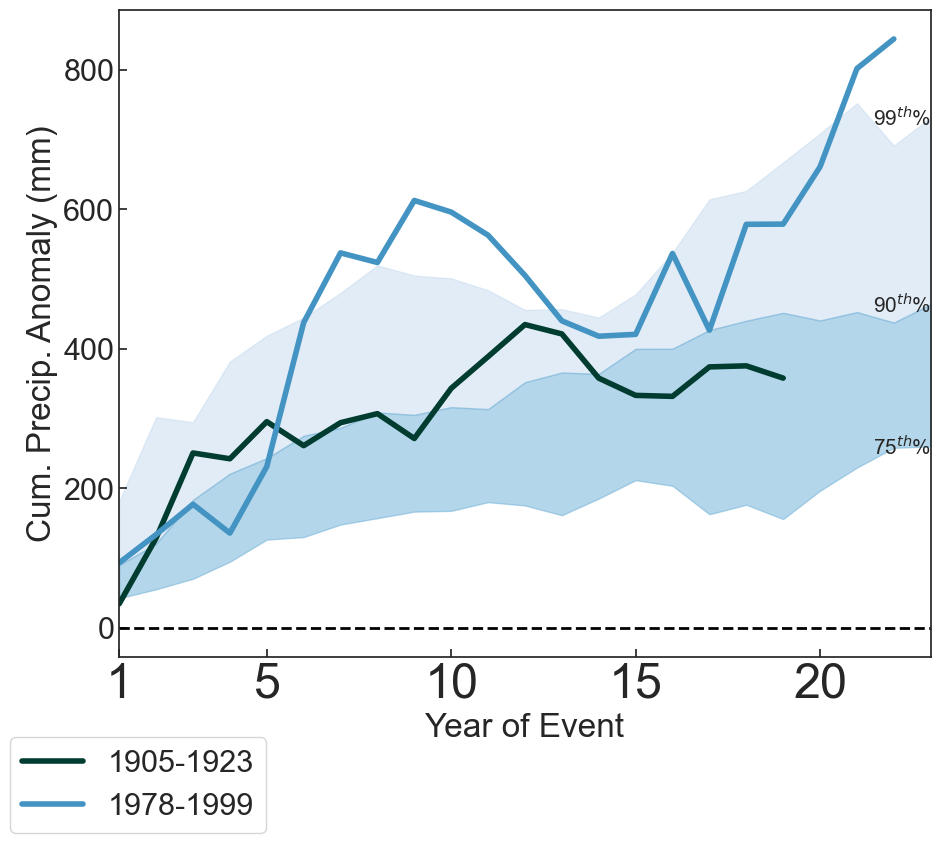

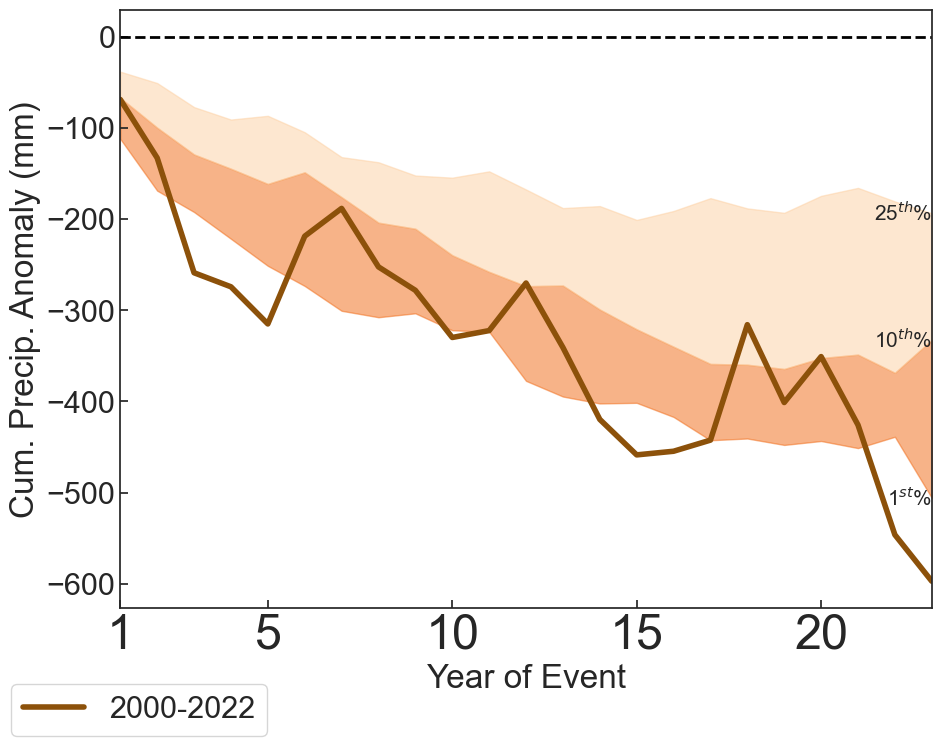

In [20]:
prec_region_anom = prec_region-np.mean(prec_region)

# Indices for events
i_1905_1923 = np.where((yrs_seas>=1905) & (yrs_seas<=1923))[0]
i_1941_1945 = np.where((yrs_seas>=1941) & (yrs_seas<=1945))[0]
i_1978_1999 = np.where((yrs_seas>=1978) & (yrs_seas<=1999))[0]
i_2000_2022 = np.where((yrs_seas>=2000) & (yrs_seas<=2022))[0]

# Years for events
cumsum_1905_1923 = np.cumsum(prec_region_anom[i_1905_1923])
cumsum_1941_1945 = np.cumsum(prec_region_anom[i_1941_1945])
cumsum_1978_1999 = np.cumsum(prec_region_anom[i_1978_1999])
cumsum_2000_2022 = np.cumsum(prec_region_anom[i_2000_2022])

# Calculate all possible 22 year cumulative-------------------------------------------------------------------------------------------

# Years to start accumulations
cum_start_yrs = np.arange(1902,1982+1);
cum_start_yrs = np.arange(1902,2000+1);

# Storage array
cum_prec_all = np.zeros((cum_start_yrs.size,23))*np.nan

# Cumulative precipitation
for n_cum in enumerate(cum_start_yrs):
    cum_prec_all[n_cum[0],:] = np.cumsum(prec_region_anom[n_cum[0]:n_cum[0]+23])

# CI Boundaries
ci_100th = np.percentile(cum_prec_all,100,axis=0)
ci_99th = np.percentile(cum_prec_all,99,axis=0)
ci_95th = np.percentile(cum_prec_all,95,axis=0)
ci_90th = np.percentile(cum_prec_all,90,axis=0)
ci_75th = np.percentile(cum_prec_all,75,axis=0)
ci_50th = np.percentile(cum_prec_all,50,axis=0)
ci_25th = np.percentile(cum_prec_all,25,axis=0)
ci_10th = np.percentile(cum_prec_all,10,axis=0)
ci_1th = np.percentile(cum_prec_all,1,axis=0)
#ci_1th = np.min(cum_prec_all,axis=0)
    
# Create Plot--------------------------------------------------------------------------------------------------------------------------

# pluvial
plt.figure(figsize=(10,9),facecolor="white")
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 1.5})
plt.plot(np.arange(1,19+1),cumsum_1905_1923,label='1905-1923',color='#003c30',linewidth=4)
plt.plot(np.arange(1,22+1),cumsum_1978_1999,label='1978-1999',color='#4393c3',linewidth=4)
#plt.plot(np.arange(1,22+1),ci_99th,color='k',linestyle='--')
plt.fill_between(np.arange(1,23+1), ci_99th, ci_90th, color='#c6dbef', alpha=0.5,zorder=0), 
plt.fill_between(np.arange(1,23+1), ci_90th, ci_75th, color='#6baed6', alpha=0.5,zorder=0)
plt.text(23,ci_99th[-1],'99$^{th}$%',fontsize=15,va='center',ha='right')
plt.text(23,ci_90th[-1],'90$^{th}$%',fontsize=15,va='center',ha='right')
plt.text(23,ci_75th[-1],'75$^{th}$%',fontsize=15,va='center',ha='right')
plt.plot(np.arange(1,24+1),np.arange(1,24+1)*0,'--', color='k', linewidth=2)
#plt.legend(loc=0)
plt.legend(loc='best', bbox_to_anchor=(0.1, 0., 0.1, -0.1))
plt.xlim(1,23)
#plt.ylim(ymin_wet,ymax_wet)
plt.xticks([1,5,10,15,20],fontsize=35)
#plt.yticks(ytick_wet,fontsize=35)
plt.ylabel('Cum. Precip. Anomaly (mm)')
plt.xlabel('Year of Event')
plt.tight_layout()
#plt.savefig('../figures/cumprec_pluvial_'+seas_txt+'.pdf',format='pdf')       

# drought
plt.figure(figsize=(10,8),facecolor="white")
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 1.5})
plt.plot(np.arange(1,23+1),cumsum_2000_2022,label='2000-2022',color='#8c510a',linewidth=4)
#plt.plot(np.arange(1,22+1),ci_99th,color='k',linestyle='--')
plt.fill_between(np.arange(1,23+1), ci_1th, ci_10th, color='#f16913', alpha=0.5,zorder=0), 
plt.fill_between(np.arange(1,23+1), ci_10th, ci_25th, color='#fdd0a2', alpha=0.5,zorder=0)
plt.text(23,ci_1th[-1],'1$^{st}$%',fontsize=15,va='center',ha='right')
plt.text(23,ci_10th[-1],'10$^{th}$%',fontsize=15,va='center',ha='right')
plt.text(23,ci_25th[-1],'25$^{th}$%',fontsize=15,va='center',ha='right')
plt.plot(np.arange(1,24+1),np.arange(1,24+1)*0,'--', color='k', linewidth=2)
#plt.legend(loc=0)
plt.legend(loc='best', bbox_to_anchor=(0.1, 0., 0.1, -0.1))
plt.xlim(1,23)
#plt.ylim(ymin_dry,ymax_dry)
plt.xticks([1,5,10,15,20],fontsize=35)
#plt.yticks(ytick_dry,fontsize=35)
plt.ylabel('Cum. Precip. Anomaly (mm)')
plt.xlabel('Year of Event')
plt.tight_layout()
#plt.savefig('../figures/cumprec_drought_'+seas_txt+'.pdf',format='pdf')       
